# Кластеризация


Кластеризация — это метод машинного обучения без учителя, при котором объекты разбиваются на группы (кластеры) так, чтобы внутри кластера объекты были похожи друг на друга, а между кластерами — различались. Например, можно сгруппировать клиентов по поведению или товары по характеристикам.

# Из методички

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Посмотрим, как работают самые базовые алгоритмы кластеризации на примере как раз такой задачи. Скачаем датасет с данными о нескольких сотнях клиентов торговой компании:

In [137]:
df = pd.read_csv('mall_customers_clustering.csv', index_col=0)
df.head()

,CustomerID,Genre,Age,Income,Score
0,1,Male,19,15000,0.39
1,2,Male,21,15000,0.81
2,3,Female,20,16000,0.06
3,4,Female,23,16000,0.77
4,5,Female,31,17000,0.40


In [138]:
df.shape

(200, 5)

In [139]:
df.isnull().sum()

,0
CustomerID,0
Genre,0
Age,0
Income,0
Score,0


Для того, чтобы представлять общую форму датасета давайте изобразим его на графике. В датасете четыре значащих признака, но один их них - пол - бинарный, что легко можно изобразить на графике цветом. Выберем еще два признака, которые расположим по осям, например:

<Axes: xlabel='Income', ylabel='Score'>

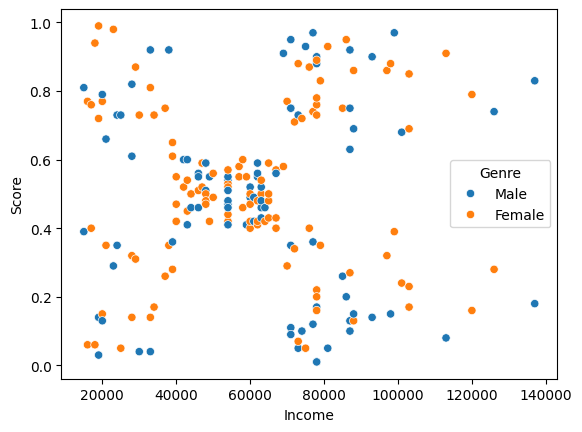

In [140]:
sns.scatterplot(x='Income' , y='Score',data=df , hue='Genre')

Для дальнейшей работы нам понадобится произвести минимальную техническую предобработку данных:

In [141]:
x = df.drop(["CustomerID"], axis=1)
X = pd.get_dummies(x)
X.head()

,Age,Income,Score,Genre_Female,Genre_Male
0,19,15000,0.39,False,True
1,21,15000,0.81,False,True
2,20,16000,0.06,True,False
3,23,16000,0.77,True,False
4,31,17000,0.40,True,False


В данном случае, мы избавились от неинформативного атрибута, и преобразовали категориальный атрибут в численные признаки.

**Кластеризация К-средних**

Для начала попробуем самый простой и распространенный алгоритм кластеризации - К-средних. Для его использования нужно импортировать соответствующий класс из пакета cluster библиотеки sklearn:

In [142]:
from sklearn.cluster import KMeans

In [143]:
k_means = KMeans(n_clusters=3, random_state=42).fit(X)

Обучение алгоритмов без учителя в библиотеке похоже на обучение с учителем, но метод fit() принимает только матрицу признаков X.

Алгоритм К-средних требует указать число кластеров — например, 3. Он разбивает данные на заданное количество кластеров.

Чтобы узнать, к какому кластеру отнесена каждая точка, используйте свойство labels_.

In [144]:
y_kmeans = k_means.labels_

Выведите этот массив и посмотрите, как обозначаются метки кластеров. А мы используем его для визуализации разделения выборки на кластеры:

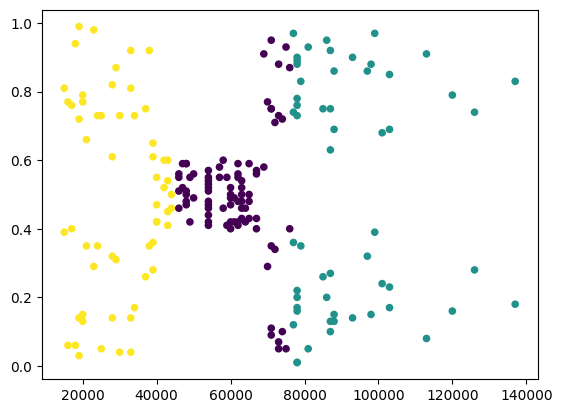

In [145]:
plt.scatter(x.Income, x.Score, c=y_kmeans, s=20, cmap='viridis')

Объект KMeans сохраняет еще одну полезную для нас информацию, которую можно использовать для визуализации - позиции центров кластеров.

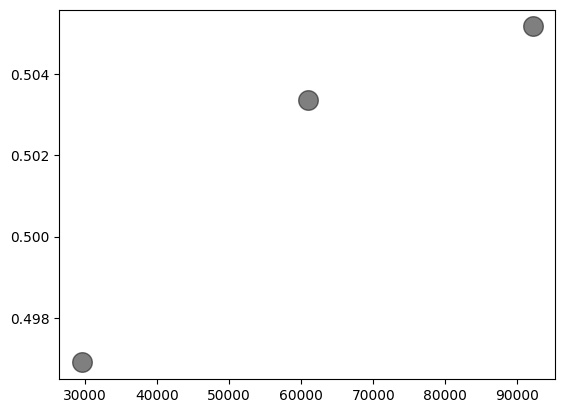

In [146]:
centers = k_means.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5)

Чтобы проверить, правильно ли выбрано число кластеров, используем метрику WCSS (инерция), которая уже есть в свойстве inertia_.

Применим метод локтя: обучим модель с количеством кластеров от 1 до 10 и построим график зависимости WCSS от числа кластеров, чтобы выбрать оптимальное значение.

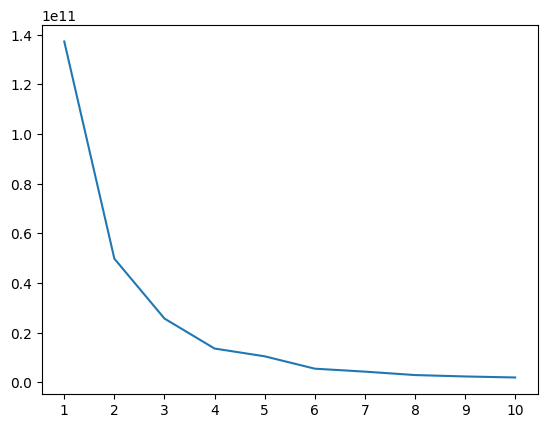

In [147]:
wcss = []
for i in range(1,11):
	k_means = KMeans(n_clusters=i,random_state=42)
	k_means.fit(X)
	wcss.append(k_means.inertia_)
plt.plot(range(1,11),wcss)
plt.xticks(range(1,11))
_ = plt.show()

Мы видим очень типичную картину: чем больше кластеров, тем меньше значение метрики WSCC. Но в начале она падает очень быстро, а при дальнейшем увеличении количества - начинает все больше выравниваться. Наша задача найти "излом" на этой кривой, то есть такое значение, после которого метрика продолжает падает уже значительно медленнее.

Давайте построим кластеризацию на 4 кластера:

In [148]:
k_means = KMeans(n_clusters=4, random_state=42).fit(X)

In [149]:
y_kmeans = k_means.labels_

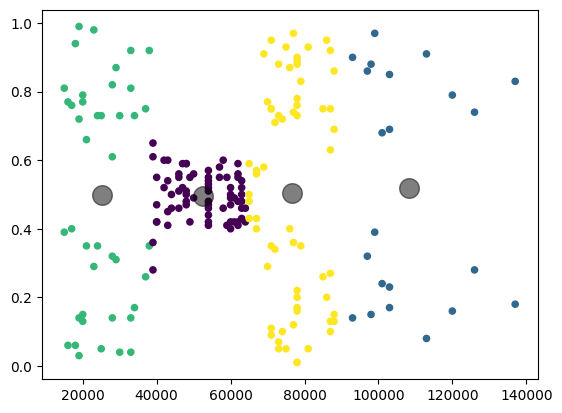

In [150]:
plt.scatter(x.Income, x.Score, c=y_kmeans, s=20, cmap='viridis')
centers = k_means.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5)

Давайте проверим его еще раз, значительно увеличив количество кластеров:

In [151]:
k_means = KMeans(n_clusters=8, random_state=42).fit(X)

In [152]:
y_kmeans = k_means.labels_

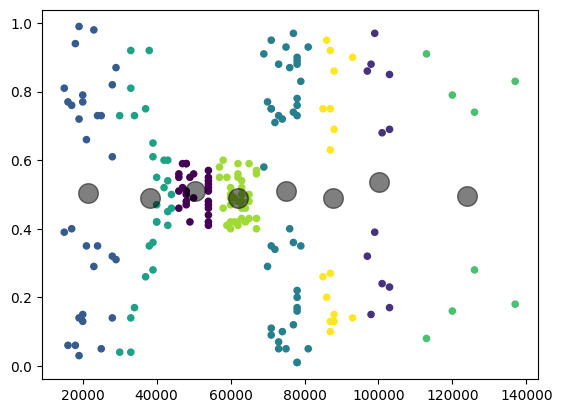

In [153]:
plt.scatter(x.Income, x.Score, c=y_kmeans, s=20, cmap='viridis')
centers = k_means.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5)

Центры кластеров подозрительно всегда располагаются вдоль одной оси. И это не кажется оптимальным, когда мы смотрим на общее расположение точек. Если вы видите такое поведение, когда странное поведение выражается вдоль определенной оси, это должно вас навести на мысль о том, что что-то не так с масштабом.

**Нормализация признаков**

Алгоритм К-средних, будучи метрическим методом, основывается на вычислении расстояний между точками выборки. Поэтому данные перед началом обучения обязательно надо нормировать. Мы воспользуемся стандартизацией, хотя здесь подошел бы и минимаксный способ.

In [154]:
from sklearn.preprocessing import StandardScaler

In [155]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Age,Income,Score,Genre_Female,Genre_Male
0,-1.424569,-1.738999,-0.434801,-1.128152,1.128152
1,-1.281035,-1.738999,1.195704,-1.128152,1.128152
2,-1.352802,-1.700830,-1.715913,0.886405,-0.886405
3,-1.137502,-1.700830,1.040418,0.886405,-0.886405
4,-0.563369,-1.662660,-0.395980,0.886405,-0.886405


<Axes: xlabel='Income', ylabel='Score'>

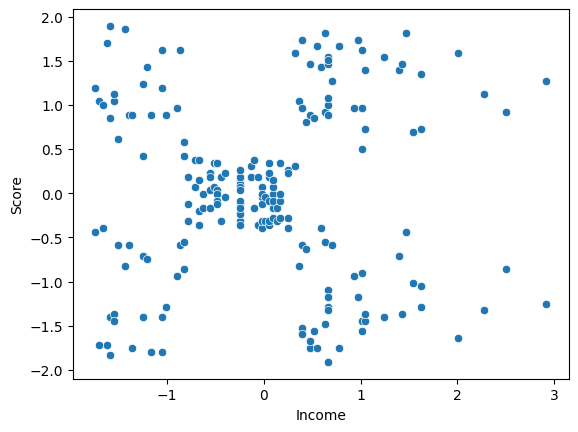

In [156]:
sns.scatterplot(x='Income' , y='Score', data=X_scaled)

Теперь давайте повторим наш анализ методом локтя. Для наглядности выведем сразу два графика: по нормализованным данным и по исходной матрице:

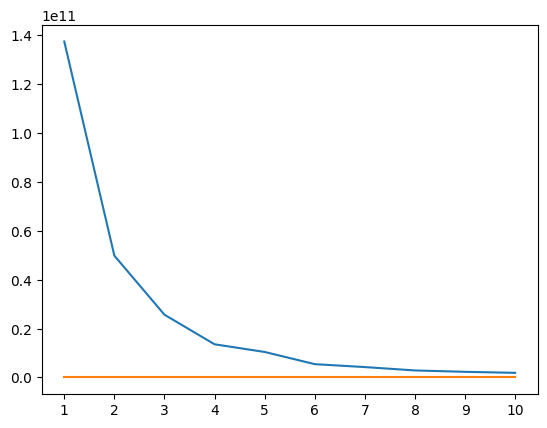

In [157]:
unscaled, scaled = [], []
for i in range(1,11):
	unscaled.append(KMeans(n_clusters=i,random_state=42).fit(X).inertia_)
	scaled.append(KMeans(n_clusters=i,random_state=42).fit(X_scaled).inertia_)
plt.plot(range(1,11),unscaled)
plt.plot(range(1,11),scaled)
plt.xticks(range(1,11))
_ = plt.show()

Если вывести только график кластеризации по нормированным данным, все станет понятнее:

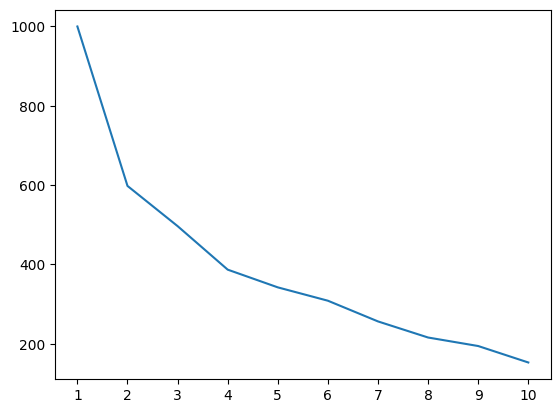

In [158]:
scaled = []
for i in range(1,11):
	scaled.append(KMeans(n_clusters=i,random_state=42).fit(X_scaled).inertia_)
plt.plot(range(1,11),scaled)
plt.xticks(range(1,11))
_ = plt.show()

Повторим обучение модели:

In [159]:
k_means = KMeans(n_clusters=4, random_state=42).fit(X_scaled)

In [160]:
y_kmeans = k_means.labels_

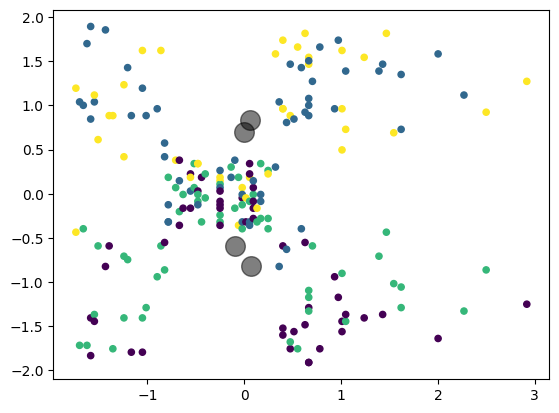

In [161]:
plt.scatter(X_scaled.Income, X_scaled.Score, c=y_kmeans, s=20, cmap='viridis')
centers = k_means.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5)

Главное, что центры кластеров уже не выстраиваются в линию параллельно одному из измерений. Однако, кластеры кажутся перемешанными. Это происходит от того, что мы смотрим на датасет в проекции. Поэтому при решении реальных задач не всегда можно опираться на визуализацию, а ориентироваться нужно в первую очередь на метрики.

Но для того, чтобы продемонстрировать то, насколько адекватно работает работает алгоритм K-средних, обучим его на плоском датасете, состоящим всего их двух признаков. Для этого удалим из матрицы лишние столбцы, оставив только те, которые выше мы использовали для визуализации:

In [162]:
X_flat = X_scaled.drop(["Age", "Genre_Female", "Genre_Male"], axis=1)
X_flat.head()

,Income,Score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


Повторим визуализацию для анализа методом локтя:

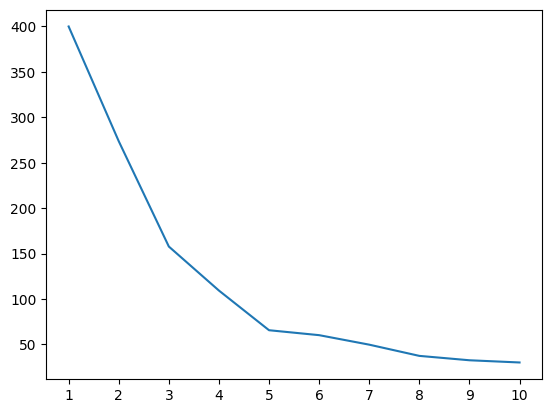

In [163]:
flat = []
for i in range(1,11):
	flat.append(KMeans(n_clusters=i,random_state=42).fit(X_flat).inertia_)
plt.plot(range(1,11),flat)
plt.xticks(range(1,11))
_ = plt.show()

Построим кластеризацию по 5 точкам:

In [164]:
k_means = KMeans(n_clusters=5, random_state=42).fit(X_flat)

In [165]:
y_kmeans = k_means.labels_

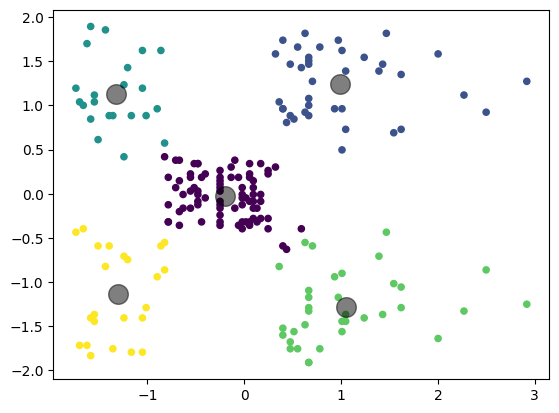

In [166]:
plt.scatter(X_flat.Income, X_flat.Score, c=y_kmeans, s=20, cmap='viridis')
centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

**Иерархическая кластеризация**

Алгоритм агломеративной кластеризации — иерархический метод, который помимо разбиения на кластеры, строит таксономию — дерево объединения по сходству. По интерфейсу он работает так же, как и другие модели кластеризации.

In [167]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [168]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_scaled)

Для построения дендрограммы в эту функцию нужно передать марицу связности в специальном виде. Мы используем готовый сниппет кода, который принимает на вход объект обученной модели агломерационной кластеризации и строит по нему дендрограмму:

In [169]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

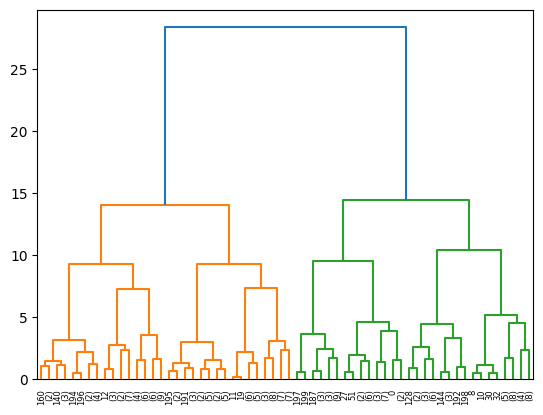

In [170]:
plot_dendrogram(model, truncate_mode="level", p=5)

При агломеративной кластеризации объекты последовательно объединяются в группы на основе близости. Это отображается на дендрограмме — графике, где по вертикали показано расстояние между кластерами, а по горизонтали — объекты. Сначала объединяются самые близкие объекты, затем — группы между собой.

Можно выбрать уровень, на котором «обрезать» дендрограмму — это определит количество кластеров. Выбор можно задать либо числом кластеров, либо порогом расстояния (параметр distance_threshold).

In [171]:
agg_clustering = AgglomerativeClustering(n_clusters=5).fit(X_scaled)
y_agg = agg_clustering.labels_

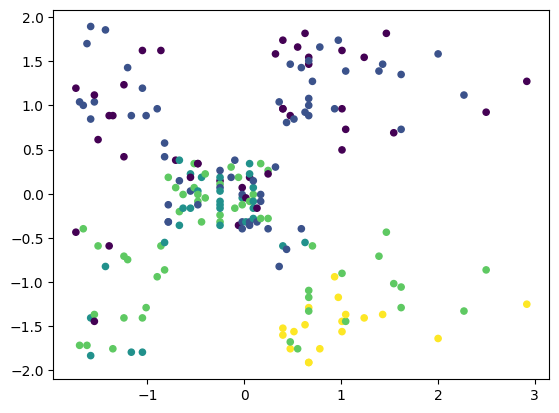

In [172]:
plt.scatter(X_scaled.Income, X_scaled.Score, c=y_agg, s=20, cmap='viridis')

Для наглядности, обучим этот алгоритм на плоских данных, чтобы показать визуально, как он объединяет точки на плоскости.

In [173]:
agg_clustering = AgglomerativeClustering(n_clusters=5).fit(X_flat)
y_agg = agg_clustering.labels_

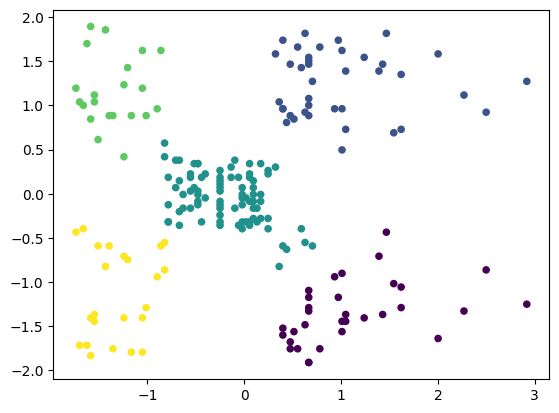

In [174]:
plt.scatter(X_flat.Income, X_flat.Score, c=y_agg, s=20, cmap='viridis')

**DBSCAN**

Еще один алгоритм кластеризации, который необходимо разобрать на практике, потому, что он использует совершенно другой подход - DBSCAN. Он оценивает плотность расположения точек в окрестностях заданной. Попробуем построить его на тех же данных (для наглядности, будем использовать плоские данные):

In [175]:
from sklearn.cluster import DBSCAN

In [176]:
db = DBSCAN(eps=0.4, min_samples=3).fit(X_flat)
y_db = db.labels_

У алгоритма DBSCAN два ключевых параметра:

eps — радиус, в пределах которого точки считаются соседями;

min_samples — минимальное число соседей, чтобы точку признать «внутренней».

Они сильно влияют на результат кластеризации и подбираются экспериментально. Вместо метрик качества можно отслеживать, сколько кластеров и «шумовых» точек получается при разных значениях параметров — это помогает выбрать подходящие настройки.

In [177]:
n_clusters_ = len(set(y_db)) - (1 if -1 in y_db else 0)
n_noise_ = list(y_db).count(-1)

Дело в том, что алгоритм DBSCAN в sklearn использует значение "-1" как метку, показывающую, что данная точка отнесена к шуму. Теперь мы можем построить график зависимости количества кластеров и шума в зависимости от значения гиперпараметра eps:

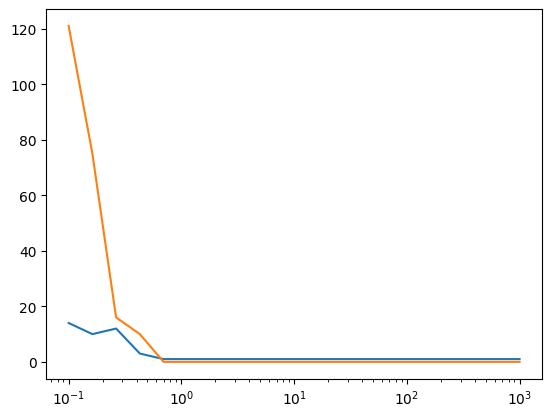

In [178]:
clusters, noise = [], []
for i in np.logspace(-1, 3, 20):
  db = DBSCAN(eps=i, min_samples=3).fit(X_flat)
  y_db = db.labels_

  clusters.append(len(set(y_db)) - (1 if -1 in y_db else 0))
  noise.append(list(y_db).count(-1))

plt.plot(np.logspace(-1, 3, 20),clusters)
plt.plot(np.logspace(-1, 3, 20),noise)
plt.xscale('log')
_ = plt.show()

Он показывает, что чем больше радиус, тем меньше и кластеров и шума получается.

Количество точек, то есть параметр min_samples тоже можно подобрать перебором. Его обычно берут в диапазон от 2 до 5, в зависимости от желаемого результата. Давайте построим кластеризацию с подобранными значениями параметров:

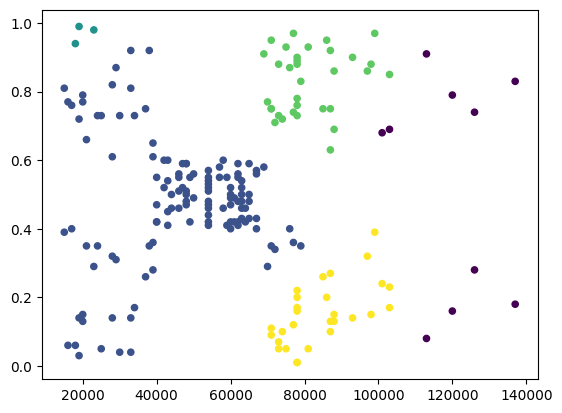

In [179]:
db = DBSCAN(eps=0.4, min_samples=3).fit(X_flat)
y_db = db.labels_

plt.scatter(X.Income, X.Score, c=y_db, s=20, cmap='viridis')

## Задания для самостоятельного выполнения


*1. Для придания смысла кластерам выведите примеры точек выборки для каждого кластера. Сделайте вывод, чем они отличаются.*

In [180]:
X = df[['Age', 'Income', 'Score']].values # только числовые признаки для кластеризации

In [181]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X) # обучение модели

In [182]:
df['Cluster'] = clusters

In [183]:
for cluster_label in set(clusters):
    print(f"Cluster {cluster_label}:")
    indices = [i for i, label in enumerate(clusters) if label == cluster_label]
    print(df.iloc[indices].head(3))
    print()

Cluster 0:
    CustomerID   Genre  Age  Income  Score  Cluster
58          59  Female   27   46000   0.51        0
59          60    Male   53   46000   0.46        0
60          61    Male   70   46000   0.56        0

Cluster 1:
     CustomerID Genre  Age  Income  Score  Cluster
144         145  Male   25   77000   0.12        1
145         146  Male   28   77000   0.97        1
146         147  Male   48   77000   0.36        1

Cluster 2:
   CustomerID   Genre  Age  Income  Score  Cluster
0           1    Male   19   15000   0.39        2
1           2    Male   21   15000   0.81        2
2           3  Female   20   16000   0.06        2



Cluster 0: В основном — молодые женщины с доходом в районе 16-17 тысяч и разными значениями Score (от очень низких до средних).

Cluster 1: Смешанный кластер — в основном женщины с доходом около 18 тысяч и низким Score, но тут также есть мужчина 64 лет с низким доходом и низким Score.

Cluster 2: В основном молодые мужчины с доходом около 15 тысяч и разным Score — от среднего до высокого. Это мужская группа с низким доходом, но активной вовлечённостью (Score).

*2. Используйте для визуализации результатов кластеризации другие пары признаков. Сделайте вывод о зависимости кластеризации от признаков.*

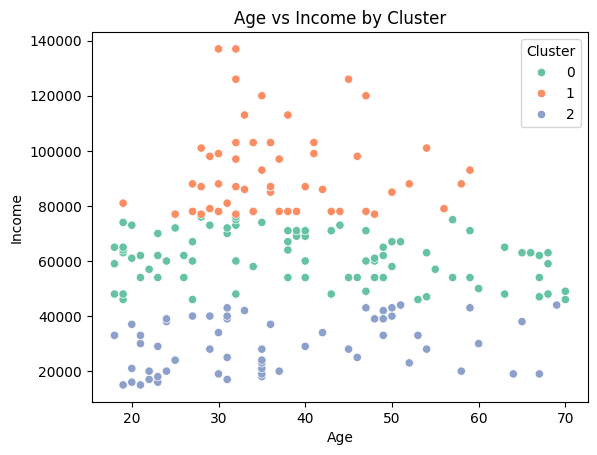

In [184]:
sns.scatterplot(data=df, x='Age', y='Income', hue='Cluster', palette='Set2')
plt.title('Age vs Income by Cluster')
plt.show()

График показывает четкую зависимость дохода от возраста с группировкой по кластерам: пик заработка приходится на возраст 40-50 лет, после чего доходы снижаются. Молодежь до 30 лет и люди старше 60 имеют значительно более низкие доходы.

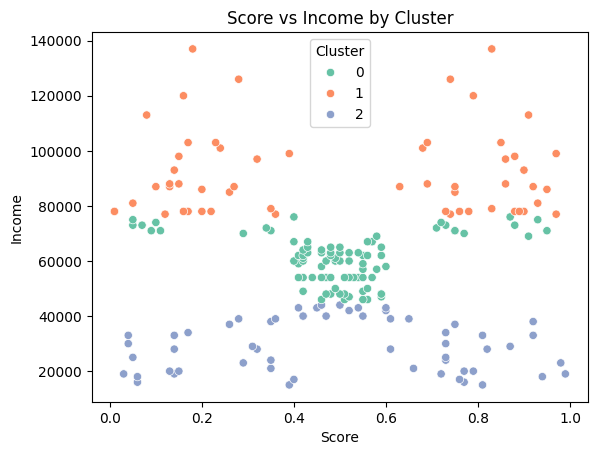

In [185]:
sns.scatterplot(data=df, x='Score', y='Income', hue='Cluster', palette='Set2')
plt.title('Score vs Income by Cluster')
plt.show()

График демонстрирует зависимость дохода от кластеров с учетом оценки (Score). Чем выше кластер (0 -> 2), тем больше доход (от 40 до 120). При этом внутри каждого кластера наблюдается прямая зависимость: рост оценки (Score) коррелирует с увеличением дохода.

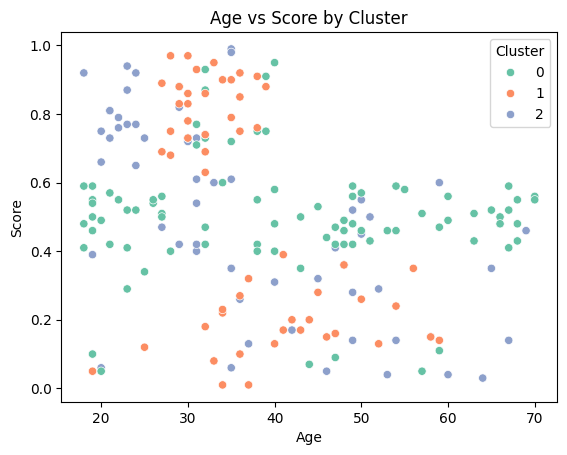

In [186]:
sns.scatterplot(data=df, x='Age', y='Score', hue='Cluster', palette='Set2')
plt.title('Age vs Score by Cluster')
plt.show()

Пик оценок приходится на средний возраст (30-50 лет), после чего показатели постепенно снижаются. Кластеры четко разделяются по уровню Score, что указывает на возрастные различия в результативности или других измеряемых параметрах. Молодые (до 30) и пожилые (после 60) демонстрируют более низкие значения.

*3. Повторите весь анализ для другого датасета - кластеризации кредитных карт.*

In [187]:
credit_card_df = pd.read_csv('credit_card_clustering.csv')

In [188]:
credit_card_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [189]:
credit_card_df.isnull().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [190]:
credit_card_df.drop(['CUST_ID', 'MINIMUM_PAYMENTS', 'CREDIT_LIMIT'], axis=1, inplace=True)

In [191]:
credit_card_df = pd.get_dummies(credit_card_df, drop_first=True) # One-Hot Encoding

In [192]:
scaler = StandardScaler().fit(credit_card_df) # стандартизация
credit_card_scaled = scaler.transform(credit_card_df)
credit_card_scaled = pd.DataFrame(credit_card_scaled, columns=credit_card_df.columns)

In [193]:
credit_card_flat = credit_card_scaled[['BALANCE', 'PURCHASES_FREQUENCY']] # выбор признаков для кластеризации (упрощение)

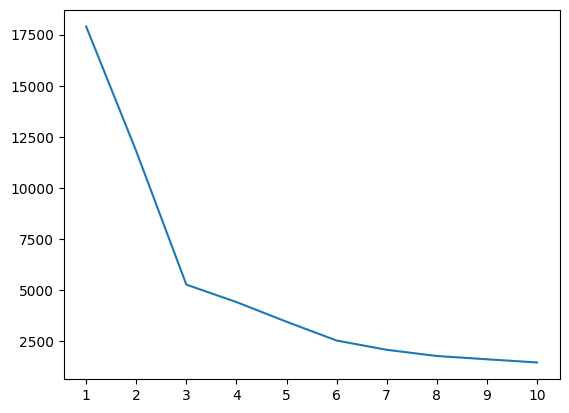

In [194]:
flat = [] # метод локтя
for i in range(1,11):
	flat.append(KMeans(n_clusters=i,random_state=42).fit(credit_card_flat).inertia_)
plt.plot(range(1,11),flat)
plt.xticks(range(1,11))
_ = plt.show()

In [195]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(credit_card_flat)
y_kmeans = kmeans.labels_

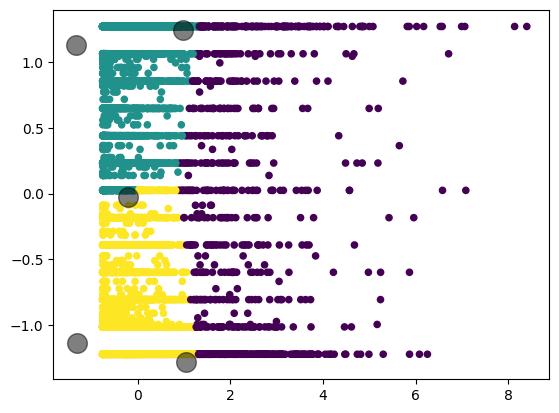

In [196]:
plt.scatter(credit_card_flat.BALANCE, credit_card_flat.PURCHASES_FREQUENCY, c=y_kmeans, cmap='viridis', s=20)
centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [197]:
agg_clustering = AgglomerativeClustering(n_clusters=4).fit(credit_card_flat) # иерархическая кластеризация
credit_card_df['Agg_Cluster'] = agg_clustering.labels_

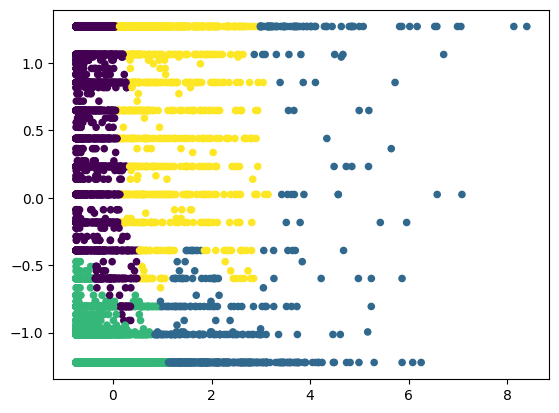

In [198]:
plt.scatter(credit_card_flat.BALANCE, credit_card_flat.PURCHASES_FREQUENCY, c=agg_clustering.labels_, cmap='viridis', s=20)
plt.show()

In [199]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(credit_card_scaled) # кластеризация по плотности

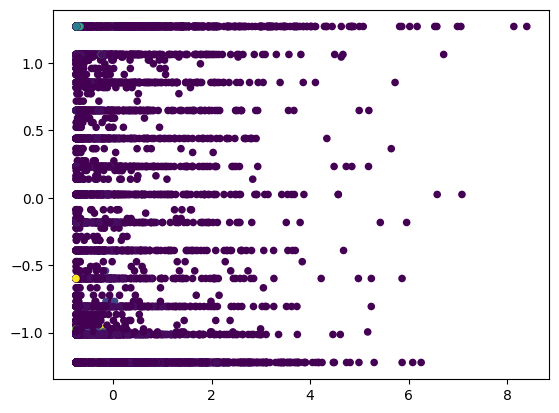

In [200]:
plt.scatter(credit_card_flat.BALANCE, credit_card_flat.PURCHASES_FREQUENCY, c=dbscan.labels_, cmap='viridis', s=20)
plt.show()

*4. В задании на иерархическую кластеризацию используйте разные методы расчета расстояния между кластерами. Сделайте выводы.*

Методы linkage:

ward -минимизирует внутрикластерную дисперсию. Хорошо работает с компактными кластерами. Предпочтителен для числовых признаков с нормализацией.

complete - максимальное расстояние между точками двух кластеров. Образует вытянутые кластеры.

average -	среднее расстояние между всеми парами точек из двух кластеров. Более сглаженная структура. Хорошо работает при шуме.

single -	минимальное расстояние между точками двух кластеров. Склонен к «цепочечным» кластерам.

In [201]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [202]:
X = credit_card_flat  # BALANCE и PURCHASES_FREQUENCY

In [203]:
link_methods = ['ward', 'complete', 'average', 'single'] # методы linkage

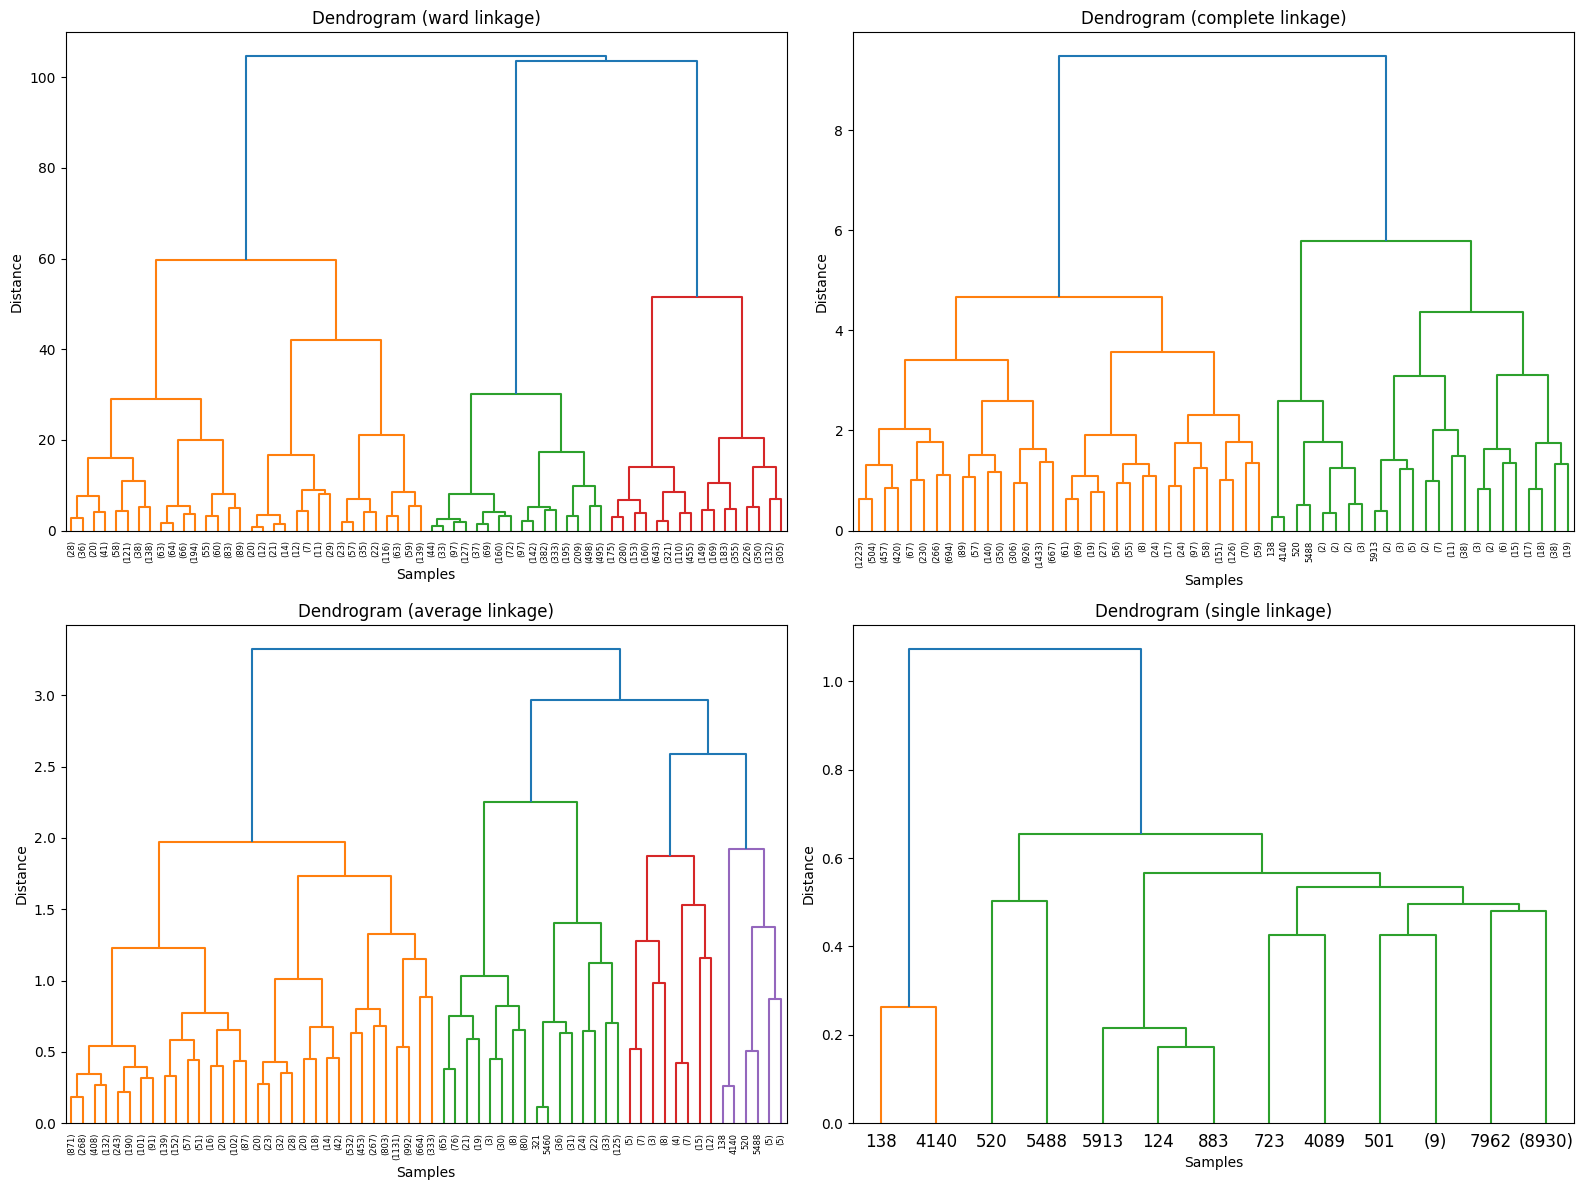

In [204]:
plt.figure(figsize=(16, 12))

for i, method in enumerate(link_methods):
    plt.subplot(2, 2, i + 1)
    Z = linkage(X, method=method) # расчет иерархической кластеризации
    dendrogram(Z, truncate_mode='level', p=5)  # отображает верхние 5 уровней иерархии
    plt.title(f'Dendrogram ({method} linkage)')
    plt.xlabel('Samples')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()


Ward linkage - напоминает аккуратное дерево с четкими ярусами; горизонтальные ступеньки явно выделены. Высокие вертикальные промежутки = кластеры статистически значимо различны.

Complete linkage - напоминает лестницу; кластеры примерно одинаковой высоты. Все кластеры имеют схожий диаметр.

Average linkage - структура с неравномерными ветвлениями, нет иерархии.

Single linkage - цепочки из последовательно соединенных точек, почти нет вертикальных промежутков. Выявляет зоны повышенной плотности.

*5. В задании на DBSCAN вычислите метрику WCSS и соотнесите результаты кластеризации через DBSCAN и К-средних.*

In [205]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.metrics import pairwise_distances

In [206]:
db = DBSCAN(eps=0.4, min_samples=3).fit(X_flat) # eps - радиус окрестности, min_samples - мин число точек в окрестности
y_db = db.labels_

In [207]:
n_clusters_ = len(set(y_db)) - (1 if -1 in y_db else 0) # число реальных кластеров
n_noise_ = list(y_db).count(-1) # число шумовых точек

In [208]:
db = DBSCAN(eps=0.4, min_samples=3).fit(X_flat)
y_db = db.labels_

WCSS - метрика для оценки качества кластеризации. Чем ниже WCSS, тем плотнее точки в кластерах.

In [209]:
def calculate_wcss(X, labels):
    unique_labels = np.unique(labels)
    wcss = 0
    for label in unique_labels:
        if label == -1:
            continue
        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0) # вычисляется центроид
        distances = pairwise_distances(cluster_points, [centroid]) # вычисляются расстояния всех точек до центроида
        wcss += np.sum(distances ** 2)
    return wcss

In [210]:
wcss = calculate_wcss(X_flat, y_db)
wcss

np.float64(128.73655636331478)

*6. Постройте кривые WCSS в зависимости от параметров DBSCAN.*

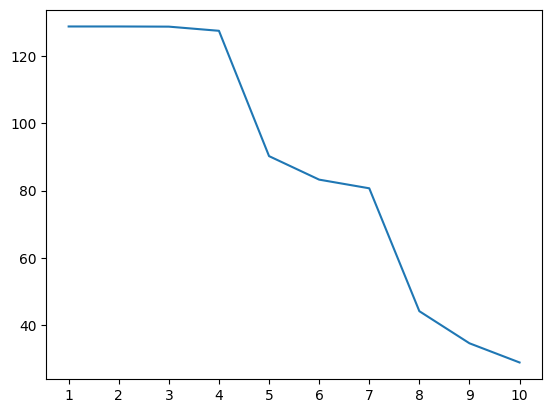

In [211]:
wcss_metrics = []
for i in range(1,11): # меняем мин кол-во точек в окрестности
    db = DBSCAN(eps=0.4, min_samples=i).fit(X_flat)
    y_db = db.labels_
    wcss = calculate_wcss(X_flat, y_db)
    wcss_metrics.append(wcss)
plt.plot(range(1,11),wcss_metrics)
plt.xticks(range(1,11))
_ = plt.show()

График показывает, что с увеличением min_samples в DBSCAN сумма квадратов расстояний (WCSS) стабильно растёт, особенно резко на участке от 1 до 3 соседей. После 5 соседей рост замедляется, что свидетельствует о стабилизации структуры кластеров. Минимальные значения WCSS при малых min_samples (1-2) указывают на риск переобучения и выделения мелких шумовых кластеров, тогда как значения выше 5 дают более устойчивую, но менее детализированную кластеризацию. Оптимальный баланс достигается в районе 3-5 соседей, где сохраняется информативность кластеров без чрезмерного роста ошибки.